# Lattice vectors for neighbor images: Max 1 out of 1 candidates.
# Model loaded from '/global/cfs/cdirs/m3538/ruiqig/wannier_centroid_3.pkl'.
SPREAD:  16.38627956
center:  [5.3534 4.5831 2.6539]
Ref center: [5.4261 4.5084 2.6294]
center diff:  0.10706626
sigma:  1.2402004  dft spread:  2.9446973119018733
E:  14.67606
Iter steps:  28
F.std():  0.24480648
F.max():  0.8499818


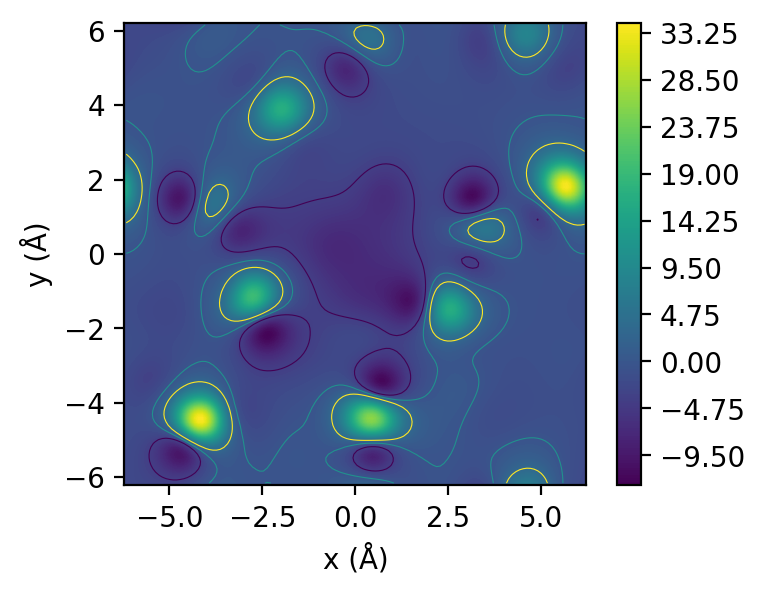

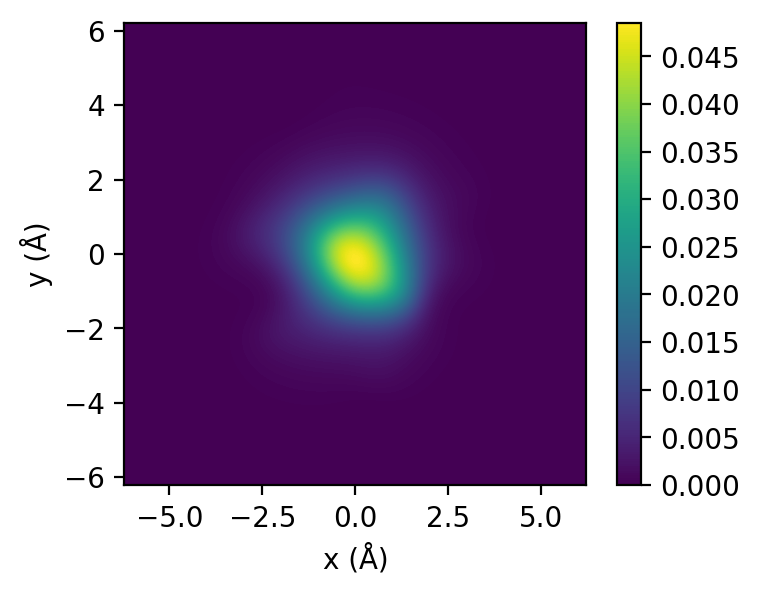

In [ ]:
# %env XLA_PYTHON_CLIENT_PREALLOCATE=false
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import jax.numpy as jnp 
import jax
import flax.linen as nn
from deepmd_jax.utils import load_model, get_p3mlr_fn
from deepmd_jax.data import compute_lattice_candidate
from functools import partial
path = '/global/cfs/cdirs/m3538/ruiqig/set.001'
N = 64
box = 12.4171
k = 198 # selected configuration index, can be changed
beta_O, beta_H, beta, mass = 2, 2, 0.6, 1
M = [128,128,128]
coords = np.load(f'{path}/coord.npy')[k].reshape(3*N+1, 3)
atomic_center = np.load(f'{path}/atomic_center.npy')[k].reshape(3)
ref_force = np.load(f'{path}/force.npy')[k].reshape(3*N+1, 3)
spread = np.load(f'{path}/spread.npy')[k]
type_idx = np.array([0,1,1] * N + [1])
lattice_args = compute_lattice_candidate(box * np.eye(3)[None], 6)
static_args = nn.FrozenDict({'type_count': (N,2*N+1), 'lattice': lattice_args})
model_wcentroid_3, variables_wcentroid_3 = load_model('/global/cfs/cdirs/m3538/ruiqig/wannier_centroid_3.pkl')
print('SPREAD: ', spread)
def plot_V(V, center=np.zeros(3)):
    idx_x = int(center[0] * M[0] / box)
    V = V[idx_x]
    idx_y, idx_z = int((-center[1] + box/2) * M[1] / box), int((-center[2] + box/2) * M[2] / box)
    V = jnp.roll(V, idx_y % M[1], axis=0)
    V = jnp.roll(V, idx_z % M[2], axis=1)
    plt.figure(figsize=(4,3))
    plt.imshow(V, origin='lower', extent=[-box/2,box/2,-box/2,box/2])
    fig = plt.contourf(V, origin='lower', extent=[-box/2,box/2,-box/2,box/2], levels=200, linewidths=1)
    # plt.contour(V, origin='lower', extent=[-box/2, box/2, -box/2, box/2], levels=np.linspace(-1.5, 1.5, 6), linewidths=0.4)
    plt.contour(V, origin='lower', extent=[-box/2, box/2, -box/2, box/2], levels=np.linspace(-4, 3, 3), linewidths=0.4)

    cbar = plt.colorbar(fig)
    plt.xlabel('x (Å)')
    plt.ylabel('y (Å)')
    plt.show()
box3 = jnp.array([box]*3)
q = jnp.array([6,1,1]*N + [1] + [-8]*N)
cube_idx = (jnp.stack(jnp.meshgrid(*([jnp.array([-1,0,1])]*3),indexing='ij'))).reshape(3,27)
MM = jnp.array(M).reshape(3,1,1,1)
kgrid = jnp.stack(jnp.meshgrid(*[jnp.arange(m) for m in M], indexing='ij'))
kgrid = 2*jnp.pi/box3[:,None,None,None] * ((kgrid-MM/2)%MM-MM/2)
ksquare = (kgrid ** 2).sum(0)
z = kgrid * (box3/jnp.array(M))[:,None,None,None] / 2
sinz = jnp.sin(z)
w3k = jnp.prod(jnp.where(z==0, 1, (sinz/z)**3), axis=0)
Sk = jnp.prod(1 - sinz**2 + 2/15*sinz**4, axis=0)
kfactor = -(14.399645*4*jnp.pi*jnp.prod(jnp.array(M))/jnp.prod(box3)) * jnp.exp(-ksquare/(4*beta_O**2)) * w3k/(Sk*ksquare)
kfactor = kfactor.at[0,0,0].set(0.)
def get_V(coords, wc):
    coord_N3 = jnp.concatenate([coords, wc])
    grid = jnp.zeros(M)
    M3 = jnp.array(M)
    coord_3N = ((coord_N3 % box3) / box3 * M3).T
    center_idx_3N = jnp.rint(coord_3N).astype(int) # in [0, M3]
    r_3N = coord_3N - center_idx_3N # lies in (-0.5, 0.5)
    fr_33N = jnp.stack([(r_3N-0.5)**2/2,
                        0.75 - r_3N**2,
                        (r_3N+0.5)**2/2]) # TSC assignment
    fr_27N = (fr_33N[:,None,None,0,:]*fr_33N[:,None,1,:]*fr_33N[:,2,:]).reshape(27,-1)
    all_idx = (center_idx_3N[:,None] + cube_idx[:,:,None]).reshape(3,-1) % M3[:,None]
    grid = grid.at[tuple(all_idx)].add((q*fr_27N).reshape(-1))
    grid = jnp.fft.ifftn(jnp.fft.fftn(grid) * kfactor).real
    return grid
def ground_state(V, tol=1e-4, max_step=100):
    n, h = V.shape[0], box / V.shape[0]
    dk  = 2*jnp.pi * jnp.fft.fftfreq(n, d=h)
    T_k = 3.809982 * (dk[:,None,None]**2 + dk[None,:,None]**2 + dk[None,None,:]**2) / mass
    mu = jnp.clip(0.5 * jnp.std(V), 1e-5 * T_k.max(), 0.05 * T_k.max())
    def solve_ground_state(V):
        psi = jax.random.normal(jax.random.PRNGKey(0), V.shape, V.dtype)
        psi /= jnp.linalg.norm(psi)
        psi_k = jnp.fft.fftn(psi)
        E = ((psi.conj() * psi).real * V).sum() + ((psi_k * psi_k.conj()).real * T_k).sum() / psi.size
        def step(state):
            for i in range(4):
                psi, psi_k, E, _, k = state
                psi_k_conj = psi_k.conj()
                res_k = jnp.fft.fftn(V * psi) + (T_k - E) * psi_k
                res_norm = jnp.sqrt((jnp.abs(res_k)**2).sum() / psi.size)
                z_k = res_k / (T_k + mu) # preconditioner
                z_ortho_k = z_k - (z_k * psi_k_conj).sum() * psi_k / psi.size
                res_ortho_k = res_k - (res_k * psi_k_conj).sum() * psi_k / psi.size
                branch = (jnp.abs(z_ortho_k)**2).sum() / psi.size < 1e-12
                b_k = jnp.where(branch, res_ortho_k, z_ortho_k) # descent direction
                b_k = b_k / (jnp.sqrt((jnp.abs(b_k)**2).sum() / psi.size))
                b = jnp.fft.ifftn(b_k)
                A12 = (psi.conj() * V * b).sum() + (psi_k_conj * T_k * b_k).sum() / psi.size
                A22 = ((b.conj() * b).real * V).sum().real + ((b_k.conj() * b_k).real * T_k).sum() / psi.size
                c0, c1 = (A22-E) + ((E-A22)**2 + 4*(A12*A12.conj()).real)**0.5, -2*A12.conj()
                psi_new = c0 * psi + (c1 * b).real
                normalizer =  (psi_new.conj() * psi_new).real.sum()**0.5
                psi_new /= normalizer
                psi_k_new = (c0 * psi_k + c1 * b_k) / normalizer
                E_new = ((psi_new.conj() * psi_new).real * V).sum() + ((psi_k_new * psi_k_new.conj()).real * T_k).sum() / psi.size
                state = (psi_new, psi_k_new, E_new, res_norm, k + 1)
            return state
        def cond(state):
            _, _, _, res_norm, k = state
            return (res_norm > tol) & (k < max_step)
        psi, _, E, _, k = jax.lax.while_loop(cond, step, (psi, psi_k, E, 1e10, 0))
        return E, psi, k
    return solve_ground_state(V)
def berry_center(rho):
    real_grid = (box/M[0]) * jnp.stack(jnp.meshgrid(*[jnp.arange(M[0])]*3, indexing='ij'), axis=0)
    s = (jnp.exp(1j * 2*jnp.pi* real_grid / box) * rho).sum(axis=(1,2,3)) / rho.sum()
    sigma = jnp.linalg.norm((box / (2 * jnp.pi)) * jnp.sqrt(-2.0 * jnp.log(jnp.abs(s))))
    center = (jnp.angle(s) * box / (2 * jnp.pi)) % box
    return center, sigma
def E_V_rho_center(coords, wc):
    V = get_V(coords, wc)
    E, psi, k = ground_state(V)
    rho = jnp.abs(psi)**2 / (box / V.shape[0])**3
    center, sigma = berry_center(rho)
    return E, V, psi, rho, center, k, sigma
def get_Hyd(coords):
    O = coords[:-1:3]
    N = O.shape[0]
    H = jnp.concatenate([coords[1::3], coords[2::3], coords[-1:]], axis=0)
    distOH = jnp.linalg.norm((O[:,None] - H[None] + box/2) % box - box/2, axis=-1)
    H2_idx = jnp.argsort(distOH, axis=-1)[:,:2].reshape(2*N)
    H_is_bonded = jnp.isin(jnp.arange(2*N+1), H2_idx)
    return H[jnp.argsort(H_is_bonded)[0]]
def solve_electron(coords):
    wc_pred = model_wcentroid_3.wc_predict(variables_wcentroid_3, coords[type_idx.argsort()], box * np.eye(3), static_args)
    E, V, psi, rho, center, k, sigma = E_V_rho_center(coords, wc_pred)
    rho = jax.lax.stop_gradient(rho)
    E0 = (rho * V).sum() * (box / M[0])**3
    E1 = jax.lax.stop_gradient(E - E0)
    return E0 + E1, (V, psi, rho, center, k, wc_pred, sigma)
    # return E0, (V, psi, rho, center, k, wc_pred, sigma)
def lr_wc(coord, beta, idx=4):
    wc_pred = model_wcentroid_3.wc_predict(variables_wcentroid_3, coord[type_idx.argsort()], box * np.eye(3), static_args)
    p3mlr_fn = get_p3mlr_fn(box * np.ones(3), beta, M=M)
    return p3mlr_fn(jnp.concatenate([coord, wc_pred]), jnp.array([6,1,1]*N + [1] + [-8]*N))
def solve_ef_electron(coords):
    (E, (V, psi, rho, center, k, wc_pred, sigma)), F = jax.value_and_grad(solve_electron, has_aux=True)(coords)
    E_lr, F_lr = jax.value_and_grad(lr_wc)(coords, beta)
    E += E_lr
    F += F_lr
    return (E, (V, psi, rho, center, k, wc_pred, sigma)), -F
(E, (V, psi, rho, center, k, wc_pred, sigma)), F = solve_ef_electron(coords)
print("center: ", center)
print("Ref center:", atomic_center)
print("center diff: ", np.linalg.norm((center - atomic_center - box/2) % box - box/2))
print("sigma: ", sigma, " dft spread: ", (spread * 0.529177)**0.5)
print("E: ", E)
print("Iter steps: ", k)
print("F.std(): ", F.std())
print("F.max(): ", F.max())
plot_V(V, center=center)
plot_V(rho, center=center)